In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import scipy
from pandarallel import pandarallel


p = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [11]:
h5 = '../../cerberus_annot.h5'
h5_annot = '../cerberus_annot_triplets.h5'
h5_annot_mouse = '../../../../mouse/lr_bulk/triplets/cerberus_annot_triplets.h5'
swan_file = '../../swan/swan.p'
mouse_swan_file = '../../../../mouse/lr_bulk/swan/swan.p'
ab = '../../../talon/human_talon_abundance.tsv'
mouse_filt_ab = '../../../../mouse/lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
filt_ab = '../../cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = '../../swan/isos_sample_gene_90.tsv'
major_set_mouse = '../../swan/isos_sample_gene_90.tsv'
mm_tissues = get_mouse_match_samples()
fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig5'
orth_table = '../../../../refs/biomart_human_to_mouse.tsv'

In [3]:
ca = cerberus.read(h5_annot)
m_ca = cerberus.read(h5_annot_mouse)
sg = swan.read(swan_file)
m_sg = swan.read(mouse_swan_file)

Read in graph from ../../swan/swan.p
Read in graph from ../../../../mouse/lr_bulk/swan/swan.p


In [4]:
# def get_human_mouse_gid_table():
#     # get matching gids from human and mouse
#     df = pd.read_csv('../../../../refs/biomart_human_to_mouse.tsv', sep='\t')

#     # drop nans in either human or mouse
#     df = df[['Gene stable ID', 'Mouse gene stable ID']]
#     df = df.loc[~df['Gene stable ID'].isnull()]
#     df = df.loc[~df['Mouse gene stable ID'].isnull()]    
    
#     df = df.drop_duplicates()
#     return df

## Compare centroid for sample_det for each gene to sample_det in mouse

In [5]:
def get_human_df(ca):
    # compute centroid for each mm sample / gene pairing for the different sources
    source = 'sample_det'
    df = ca.triplets.loc[(ca.triplets.source == source)&(ca.triplets['sample'].isin(mm_tissues))].copy(deep=True)
    # df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    keep_cols = ['gname', 'gid', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso']
    df = df[keep_cols]
    df = df.groupby(['gname', 'gid']).mean().reset_index()
    df = assign_sector(df)
    
    # only protein coding genes
    gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'biotype']]
    df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
    df = df.loc[df.biotype=='protein_coding']
    
    return df

In [6]:
def get_mouse_df(ca):
    # compute centroid for each mm sample / gene pairing for the different sources
    source = 'sample_det'
    df = ca.triplets.loc[(ca.triplets.source == source)].copy(deep=True)
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    keep_cols = ['gname', 'gid', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso']
    df = df[keep_cols]
    df = df.groupby(['gname', 'gid']).mean().reset_index()
    df = assign_sector(df)
    
    # only protein coding genes
    gene_df, _, _ = get_gtf_info(how='gene', ver='vM25_cerberus', add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'biotype']]
    df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
    df = df.loc[df.biotype=='protein_coding']
    
    return df

In [7]:
# compute centroid for each mm sample / gene pairing for the different sources
h_df = get_human_df(ca)
m_df = get_mouse_df(m_ca)

print(len(h_df.index))
print(len(m_df.index))

16090
17334


In [12]:
mh_df = get_human_mouse_gid_table(orth_table)
print(len(mh_df.index))

16734


In [13]:
# merge in mouse gids that we need
df = h_df.merge(mh_df, how='left', left_on='gid', right_on='Gene stable ID')

# merge in mouse data
df = df.merge(m_df, how='inner', left_on='Mouse gene stable ID', right_on='gid', suffixes=('_human', '_mouse'))

In [14]:
df.loc[df.gid_human.duplicated(keep=False)].sort_values(by='gid_human')

,gname_human,gid_human,tss_ratio_human,tes_ratio_human,spl_ratio_human,n_iso_human,sector_human,gid_stable_human,biotype_human,Gene stable ID,Mouse gene stable ID,gname_mouse,gid_mouse,tss_ratio_mouse,tes_ratio_mouse,spl_ratio_mouse,n_iso_mouse,sector_mouse,gid_stable_mouse,biotype_mouse


In [15]:
# compute distances
pandarallel.initialize(nb_workers=8, verbose=1)
df['dist'] = df.parallel_apply(simplex_dist,
                               args=('_human', '_mouse'),
                               axis=1)

In [16]:
df.head()

,gname_human,gid_human,tss_ratio_human,tes_ratio_human,spl_ratio_human,n_iso_human,sector_human,gid_stable_human,biotype_human,Gene stable ID,...,gname_mouse,gid_mouse,tss_ratio_mouse,tes_ratio_mouse,spl_ratio_mouse,n_iso_mouse,sector_mouse,gid_stable_mouse,biotype_mouse,dist
0,A1BG,ENSG00000121410,0.306397,0.427609,0.265993,1.444444,mixed,ENSG00000121410,protein_coding,ENSG00000121410,...,A1bg,ENSMUSG00000022347,0.333333,0.333333,0.333333,1.000000,simple,ENSMUSG00000022347,protein_coding,0.071462
1,A2M,ENSG00000175899,0.340071,0.197813,0.462116,5.166667,mixed,ENSG00000175899,protein_coding,ENSG00000175899,...,A2m,ENSMUSG00000030111,0.333333,0.333333,0.333333,1.000000,simple,ENSMUSG00000030111,protein_coding,0.118292
2,A4GALT,ENSG00000128274,0.335897,0.232508,0.431595,4.000000,mixed,ENSG00000128274,protein_coding,ENSG00000128274,...,A4galt,ENSMUSG00000047878,0.262843,0.402434,0.334723,1.846154,mixed,ENSMUSG00000047878,protein_coding,0.129663
3,AAAS,ENSG00000094914,0.239435,0.170247,0.590319,4.333333,splicing,ENSG00000094914,protein_coding,ENSG00000094914,...,Aaas,ENSMUSG00000036678,0.265591,0.265591,0.468817,1.935484,mixed,ENSMUSG00000036678,protein_coding,0.095331
4,AACS,ENSG00000081760,0.223280,0.175661,0.601058,4.333333,splicing,ENSG00000081760,protein_coding,ENSG00000081760,...,Aacs,ENSMUSG00000029482,0.310955,0.228864,0.460181,2.451613,mixed,ENSMUSG00000029482,protein_coding,0.100284


In [17]:
len(df.index)

13536

In [ ]:
df.to_csv('sample_det_mouse_v_human_dist.tsv', sep='\t', index=False)

In [ ]:
df.sort_values(by='dist', ascending=False)[['gname_human', 'dist', 'sector_human', 'sector_mouse']].head(40).tail(20)

## Looking at the results

In [16]:
df = pd.read_csv('sample_det_mouse_v_human_dist.tsv', sep='\t')

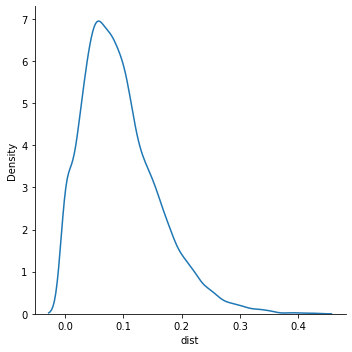

In [17]:
sns.displot(data=df, x='dist', kind='kde')

In [18]:
df = df.sort_values(by='dist', ascending=False)
df.index = [i for i in range(len(df.index))]
df.loc[df.gname_human=='ARF4']

,gname_human,gid_human,tss_ratio_human,tes_ratio_human,spl_ratio_human,n_iso_human,sector_human,gid_stable_human,biotype_human,Gene stable ID,...,gname_mouse,gid_mouse,tss_ratio_mouse,tes_ratio_mouse,spl_ratio_mouse,n_iso_mouse,sector_mouse,gid_stable_mouse,biotype_mouse,dist
34,ARF4,ENSG00000168374,0.206614,0.206614,0.586772,3.111111,splicing,ENSG00000168374,protein_coding,ENSG00000168374,...,Arf4,ENSMUSG00000021877,0.315754,0.547987,0.136259,3.387097,tes,ENSMUSG00000021877,protein_coding,0.348437


In [19]:
# how many genes have far distances in the simplex between human and mouse?
thresh = 0.2
n = len(df.index)
n_num = len(df.loc[df.dist >= thresh].index)
print('{:.2f}% of protein-coding genes in mouse and human ({}/{}) have a distance >= {} between species'.format((n_num/n)*100,n_num,n,thresh))

7.20% of protein-coding genes in mouse and human (1099/15258) have a distance >= 0.2 between species


In [20]:
# how many genes have far distances in the simplex between human and mouse?
thresh = 0.3
n = len(df.index)
n_num = len(df.loc[df.dist >= thresh].index)
print('{:.2f}% of protein-coding genes in mouse and human ({}/{}) have a distance >= {} between species'.format((n_num/n)*100,n_num,n,thresh))

0.83% of protein-coding genes in mouse and human (126/15258) have a distance >= 0.3 between species


/Users/fairliereese/mortazavi_lab/documents/rnawg/fig5/mouse_v_human_sample_det_centroid_zscore_dist.pdf


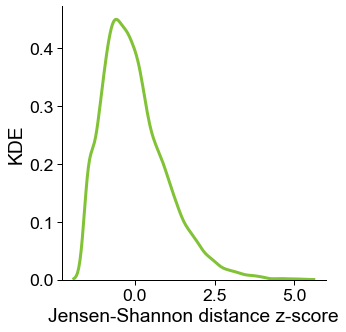

In [21]:
# calc z scores and use these to quantiy
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
df['z_score'] = st.zscore(df.dist.tolist())

ax = sns.displot(data=df, x='z_score', kind='kde', linewidth=3, color='#81c236')
xlabel = 'Jensen-Shannon distance z-score'
ylabel = 'KDE'
ax.set(xlabel=xlabel, ylabel=ylabel)
fname = '{}/mouse_v_human_sample_det_centroid_zscore_dist.pdf'.format(fig_dir)
print(fname)
plt.savefig(fname, dpi=300)

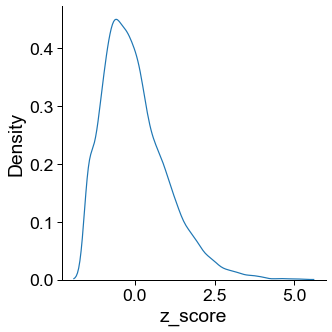

In [33]:
sns.displot(data=df, x='z_score', kind='kde')

In [34]:
# how many genes have far distances in the simplex between human and mouse?
thresh = 2
n = len(df.index)
n_num = len(df.loc[df.z_score >= thresh].index)
print('{:.2f}% of protein-coding genes in mouse and human ({}/{}) have a zscore >= {} between species'.format((n_num/n)*100,n_num,n,thresh))

4.29% of protein-coding genes in mouse and human (655/15258) have a zscore >= 2 between species


In [15]:
# how many genes have far distances in the simplex between human and mouse?
thresh = 3
n = len(df.index)
n_num = len(df.loc[df.z_score >= thresh].index)
print('{:.2f}% of protein-coding genes in mouse and human ({}/{}) have a zscore >= {} between species'.format((n_num/n)*100,n_num,n,thresh))

1.23% of protein-coding genes in mouse and human (2/162) have a zscore >= 3 between species


In [35]:
df.loc[df.gname_human == 'ARF4']

,gname_human,gid_human,tss_ratio_human,tes_ratio_human,spl_ratio_human,n_iso_human,sector_human,gid_stable_human,biotype_human,Gene stable ID,...,gid_mouse,tss_ratio_mouse,tes_ratio_mouse,spl_ratio_mouse,n_iso_mouse,sector_mouse,gid_stable_mouse,biotype_mouse,dist,z_score
34,ARF4,ENSG00000168374,0.206614,0.206614,0.586772,3.111111,splicing,ENSG00000168374,protein_coding,ENSG00000168374,...,ENSMUSG00000021877,0.315754,0.547987,0.136259,3.387097,tes,ENSMUSG00000021877,protein_coding,0.348437,3.924843


## GO on z-scores >= 3

In [24]:
thresh = 3
opref = 'human_mouse_z_score_genes_{}'.format(thresh)
df = df.loc[df.z_score >= thresh]
gids = df.gid_human.tolist()

In [25]:
dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
bm = gp.parser.Biomart()
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
datasets.loc[datasets.Description.str.contains('Human')]


desc = opref
odir = '{}_genes_GO'.format(opref)
gids = bm.query(dataset='hsapiens_gene_ensembl',
       attributes=['ensembl_gene_id', 'external_gene_name'],
       filters={'ensembl_gene_id': gids})
gids = gids.loc[~gids.external_gene_name.isna()]
gnames = gids.external_gene_name.squeeze().str.strip().tolist()
go = gp.enrichr(gene_list=gnames,
                gene_sets=dbs,
                organism='Human',
                description=desc,
                outdir=odir,
                cutoff=0.5)

In [26]:
df.to_csv('sample_det_mouse_v_human_dist.tsv', sep='\t', index=False)

## Simplex plots

In [36]:
ca = cerberus.read(h5_annot)
m_ca = cerberus.read(h5_annot_mouse)
sg = swan.read(swan_file)
m_sg = swan.read(mouse_swan_file)

Read in graph from ../../swan/swan.p
Read in graph from ../../../../mouse/lr_bulk/swan/swan.p


In [37]:
# compute centroid for each mm sample / gene pairing for the different sources
h_df = get_human_df(ca)
m_df = get_mouse_df(m_ca)

In [38]:
df = pd.read_csv('sample_det_mouse_v_human_dist.tsv', sep='\t')

In [39]:
# add centroid as coord
h_df['source'] = 'sample_det_centroid'
m_df['source'] = 'sample_det_centroid'
ca.triplets = pd.concat([ca.triplets, h_df], axis=0)
m_ca.triplets = pd.concat([m_ca.triplets, m_df], axis=0)

In [40]:
def plot_human_mouse(ca, m_ca, df, gene, odir):
    
    # get mouse gene name
    gene_mouse = df.loc[df.gname_human==gene, 'gname_mouse'].values[0]

    # human
    c_dict, order = get_biosample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'v40': '*', 'v29': 'x', 'obs_mm_det': '^', 'cerberus': '2', 'sample_det_centroid': 'x'} 
    subset = {'source': ['v40', 'obs_mm_det', 'sample_det', 'sample_det_centroid']}

    # can't subset the way that I want because I want to use and and or logic...
    ca.triplets = ca.triplets.loc[ca.triplets.source.isin(subset['source'])]
    print(ca.triplets.source.unique())
    ca.triplets = ca.triplets.loc[(ca.triplets.source!='sample_det')|(ca.triplets['sample'].isin(mm_tissues))]
    print(ca.triplets.source.unique())
    print(ca.triplets['sample'].unique())
    
    
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset=subset,
                size_scale=0.5,
                fname='{}/simplex_{}.pdf'.format(odir, gene.lower()))

    # mouse
    c_dict, order = get_lr_bulk_sample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'vM25': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2', 'sample_det_centroid': 'x'} 
    subset = {'source': ['vM25', 'obs_det', 'sample_det', 'sample_det_centroid']}
    df = m_ca.plot_simplex(top='splicing_ratio', 
                gene=gene_mouse,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset=subset,
                size_scale=0.5,
                fname='{}/simplex_mouse_{}.pdf'.format(odir, gene.lower()))

['v40' 'sample_det' 'obs_mm_det' 'sample_det_centroid']
['v40' 'sample_det' 'obs_mm_det' 'sample_det_centroid']
[nan 'heart' 'brain' 'wtc11' 'pgp1_astro' 'muscle' 'h1' 'adrenal gland'
 'h9_osteocyte' 'pgp1_excite_neuron']


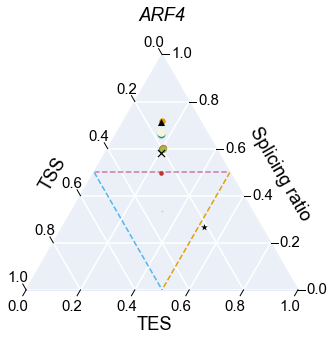

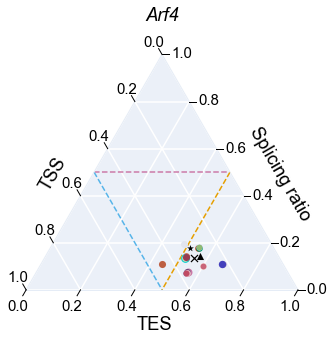

In [41]:
plot_human_mouse(ca, m_ca, df, 'ARF4', fig_dir)

In [20]:
ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='ARF4')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
22776,sample_det,ENSG00000168374,1.0,1.0,3.0,3.0,3.0,0.200000,0.200000,0.600000,ARF4,brain,88.595078,NaN,NaN,NaN
146030,sample_det,ENSG00000168374,1.0,1.0,4.0,4.0,4.0,0.166667,0.166667,0.666667,ARF4,pgp1_astro,326.434998,NaN,NaN,NaN
233010,sample_det,ENSG00000168374,1.0,1.0,3.0,3.0,3.0,0.200000,0.200000,0.600000,ARF4,h1,240.441605,NaN,NaN,NaN
287330,sample_det,ENSG00000168374,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,ARF4,muscle,26.309940,NaN,NaN,NaN
310874,sample_det,ENSG00000168374,1.0,1.0,3.0,3.0,3.0,0.200000,0.200000,0.600000,ARF4,wtc11,240.854675,NaN,NaN,NaN
396004,sample_det,ENSG00000168374,1.0,1.0,2.0,2.0,2.0,0.250000,0.250000,0.500000,ARF4,heart,58.211140,NaN,NaN,NaN
542445,sample_det,ENSG00000168374,1.0,1.0,3.0,3.0,3.0,0.200000,0.200000,0.600000,ARF4,pgp1_excite_neuron,174.750427,NaN,NaN,NaN
555578,sample_det,ENSG00000168374,1.0,1.0,5.0,5.0,5.0,0.142857,0.142857,0.714286,ARF4,adrenal gland,142.368027,NaN,NaN,NaN
576900,sample_det,ENSG00000168374,1.0,1.0,4.0,4.0,4.0,0.166667,0.166667,0.666667,ARF4,h9_osteocyte,572.059448,NaN,NaN,NaN


In [30]:
m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Arf4')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,tissue
79725,sample_det,ENSMUSG00000021877,2.0,3.0,2.0,3.0,0.800000,0.344828,0.517241,0.137931,Arf4,adrenal,192.309082,NaN
79726,sample_det,ENSMUSG00000021877,2.0,3.0,2.0,3.0,0.800000,0.344828,0.517241,0.137931,Arf4,adrenal_10d,191.445343,NaN
79727,sample_det,ENSMUSG00000021877,2.0,3.0,2.0,4.0,0.800000,0.344828,0.517241,0.137931,Arf4,adrenal_14d,186.728561,NaN
79728,sample_det,ENSMUSG00000021877,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,Arf4,adrenal_18-20mo,146.663651,NaN
79729,sample_det,ENSMUSG00000021877,2.0,3.0,2.0,3.0,0.800000,0.344828,0.517241,0.137931,Arf4,adrenal_25d,196.478851,NaN
79730,sample_det,ENSMUSG00000021877,2.0,2.0,1.0,3.0,0.500000,0.444444,0.444444,0.111111,Arf4,adrenal_2mo,196.195892,NaN
79731,sample_det,ENSMUSG00000021877,2.0,3.0,2.0,3.0,0.800000,0.344828,0.517241,0.137931,Arf4,adrenal_36d,171.244308,NaN
79732,sample_det,ENSMUSG00000021877,2.0,4.0,2.0,5.0,0.666667,0.300000,0.600000,0.100000,Arf4,adrenal_4d,190.771164,NaN
79733,sample_det,ENSMUSG00000021877,2.0,3.0,1.0,5.0,0.400000,0.370370,0.555556,0.074074,Arf4,c2c12_myoblast,351.628815,NaN
79734,sample_det,ENSMUSG00000021877,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,Arf4,c2c12_myotube,146.246033,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1815: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


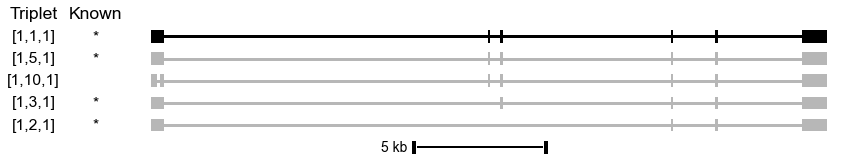

In [31]:
gene = 'ARF4'
obs_col = 'sample'
obs_condition = 'adrenal gland'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

In [32]:
m_sg.adata.obs['sample'].unique()

array(['hippocampus_18-20mo', 'cortex_18-20mo', 'adrenal_18-20mo',
       'adrenal_10d', 'hippocampus_14d', 'cortex', 'heart_18-20mo',
       'adrenal', 'adrenal_4d', 'hippocampus_2mo', 'gastroc_36d',
       'hippocampus', 'c2c12_myotube', 'gastroc_4d', 'f1219',
       'adrenal_2mo', 'gastroc_14d', 'gastroc_25d', 'cortex_14d',
       'gastroc_18-20mo', 'gastroc_2mo', 'gastroc_10d', 'adrenal_36d',
       'adrenal_25d', 'cortex_2mo', 'adrenal_14d', 'c2c12_myoblast',
       'heart_2mo', 'forelimb_e11', 'heart_14d', 'forelimb_e13'],
      dtype=object)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450
Found 37 total samples
15.711947626841242
17.571194762684122


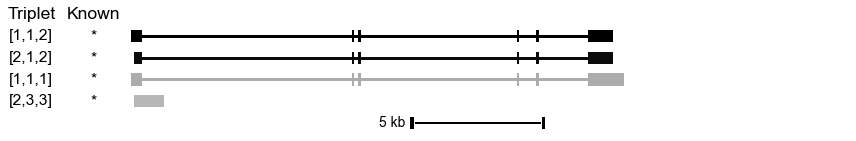

In [33]:
gene = 'Arf4'
obs_col = 'sample'
obs_condition = 'adrenal_14d'
ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
                             obs_col, obs_condition,
                             mouse_filt_ab, major_set_mouse,
                             h=0.2, ref_source='vM25', species='mouse')

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2033: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2032: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 50 total samples


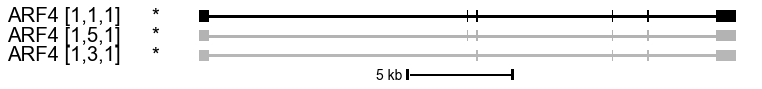

In [43]:
gene = 'ARF4'
obs_col = 'sample'
obs_condition = 'h1'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2)
fname = 'figures/{}_{}_human_browser.pdf'.format(gene.lower(), obs_condition)
plt.savefig(fname, dpi=300)

fname = '{}/{}_{}_human_browser.pdf'.format(fig_dir, gene.lower(), obs_condition)
plt.savefig(fname, dpi=300)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450
Found 37 total samples


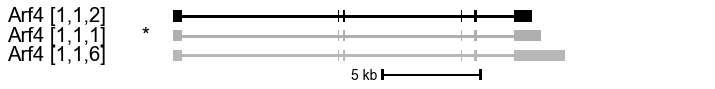

In [44]:
gene = 'Arf4'
obs_col = 'sample'
obs_condition = 'f1219'
ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
                             obs_col, obs_condition,
                             mouse_filt_ab, major_set_mouse,
                             h=0.2, species='mouse')
fname = 'figures/{}_{}_mouse_browser.pdf'.format(gene.lower(), obs_condition)
plt.savefig(fname, dpi=300)

fname = '{}/{}_{}_mouse_browser.pdf'.format(fig_dir, gene.lower(), obs_condition)
plt.savefig(fname, dpi=300)

In [37]:
# plot_human_mouse(ca, m_ca, df, 'NVL')

In [38]:
# ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='NVL')]

In [39]:
# m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Nvl')]

In [40]:
# gene = 'NVL'
# obs_col = 'sample'
# obs_condition = 'h1'
# ax, tpm_df = plot_browser_isos(ca, sg, gene,
#                              obs_col, obs_condition,
#                              filt_ab, major_set,
#                              h=0.2, ref_source='v40')

In [41]:
# gene = 'Nvl'
# obs_col = 'sample'
# obs_condition = 'f1219'
# ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
#                              obs_col, obs_condition,
#                              mouse_filt_ab, major_set_mouse,
#                              h=0.2, ref_source='vM25', species='mouse')

In [42]:
# plot_human_mouse(ca, m_ca, df, 'CERS4')

In [27]:
# ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='CERS4')]

In [43]:
# gene = 'CERS4'
# obs_col = 'sample'
# obs_condition = 'h1'
# ax, tpm_df = plot_browser_isos(ca, sg, gene,
#                              obs_col, obs_condition,
#                              filt_ab, major_set,
#                              h=0.2, ref_source='v40')

In [26]:
# m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Cers4')]

In [44]:
# gene = 'Cers4'
# obs_col = 'sample'
# obs_condition = 'f1219'
# ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
#                              obs_col, obs_condition,
#                              mouse_filt_ab, major_set_mouse,
#                              h=0.2, ref_source='vM25', species='mouse')

In [45]:
# plot_human_mouse(ca, m_ca, df, 'MAPRE1')

In [46]:
# ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='M2APRE1')]

In [47]:
# m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Mapre1')]

In [48]:
# gene = 'MAPRE1'
# obs_col = 'sample'
# obs_condition = 'h1'
# ax, tpm_df = plot_browser_isos(ca, sg, gene,
#                              obs_col, obs_condition,
#                              filt_ab, major_set,
#                              h=0.2, ref_source='v40')

In [49]:
# gene = 'Mapre1'
# obs_col = 'sample'
# obs_condition = 'f1219'
# ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
#                              obs_col, obs_condition,
#                              mouse_filt_ab, major_set_mouse,
#                              h=0.2, ref_source='vM25', species='mouse')

In [50]:
# plot_human_mouse(ca, m_ca, df, 'GTF2F1')

In [51]:
# ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='GTF2F1')]

In [52]:
# m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Gtf2f1')]

In [53]:
# gene = 'GTF2F1'
# obs_col = 'sample'
# obs_condition = 'h1'
# ax, tpm_df = plot_browser_isos(ca, sg, gene,
#                              obs_col, obs_condition,
#                              filt_ab, major_set,
#                              h=0.2, ref_source='v40')

In [54]:
# gene = 'Gtf2f1'
# obs_col = 'sample'
# obs_condition = 'f1219'
# ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
#                              obs_col, obs_condition,
#                              mouse_filt_ab, major_set_mouse,
#                              h=0.2, ref_source='vM25', species='mouse')

In [55]:
# plot_human_mouse(ca, m_ca, df, 'PIGX')

In [56]:
# ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='PIGX')]

In [57]:
# m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Pigx')]

In [58]:
# gene = 'PIGX'
# obs_col = 'sample'
# obs_condition = 'brain'
# ax, tpm_df = plot_browser_isos(ca, sg, gene,
#                              obs_col, obs_condition,
#                              filt_ab, major_set,
#                              h=0.2, ref_source='v40')

In [59]:
# obs_condition = 'cortex_14d'
# gene = 'Pigx'
# obs_col = 'sample'
# obs_condition = 'cortex_14d'
# ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
#                              obs_col, obs_condition,
#                              mouse_filt_ab, major_set_mouse,
#                              h=0.2, ref_source='vM25', species='mouse')

In [60]:
# plot_human_mouse(ca, m_ca, df, 'PPFIBP1')

In [61]:
# ca.triplets.loc[(ca.triplets.source=='sample_det')&(ca.triplets.gname=='PPFIBP1')]

In [62]:
# m_ca.triplets.loc[(m_ca.triplets.source=='sample_det')&(m_ca.triplets.gname=='Ppfibp1')]

In [63]:
# gene = 'PPFIBP1'
# obs_col = 'sample'
# obs_condition = 'heart'
# ax, tpm_df = plot_browser_isos(ca, sg, gene,
#                              obs_col, obs_condition,
#                              filt_ab, major_set,
#                              h=0.2, ref_source='v40')

In [64]:
# gene = 'Ppfibp1'
# obs_col = 'sample'
# obs_condition = 'heart_2mo'
# ax, tpm_df = plot_browser_isos(m_ca, m_sg, gene,
#                              obs_col, obs_condition,
#                              mouse_filt_ab, major_set_mouse,
#                              h=0.2, ref_source='vM25', species='mouse')